# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset(use_raw=True,)

In [3]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [4]:
def plot_gallery(images, h=data.shape[1], w=data.shape[2], n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [5]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [6]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [7]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [8]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 10

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

inp_enc = tf.keras.Input(X_train.shape[1])
x = L.Dense(400, activation = 'relu')(inp_enc) # , kernel_initializer='he_normal'
mu_enc = L.Dense(dimZ, name='mu_encoder')(x)
sigma_enc = L.Dense(dimZ, name='sigma_encoder')(x)

epsilon = tf.random.normal(tf.shape(mu_enc))
sampled_distr = mu_enc + tf.exp(0.5 * sigma_enc)*epsilon
encoder = tf.keras.Model(inputs = inp_enc, outputs = [mu_enc, sigma_enc, sampled_distr]) # output should be mean, variance and a sample

inp_dec = tf.keras.Input(dimZ)
x = L.Dense(400, activation = 'relu')(inp_dec)
reconstr = L.Dense(X_train.shape[1], activation ='sigmoid', name='reconstructed_image')(x)
#log_sigma_decoder = L.Dense(X_train.shape[1], name='log_sigma_decoder')(x)
decoder = tf.keras.Model(inputs = inp_dec, outputs = reconstr)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [9]:
from tensorflow.keras.optimizers import Adam

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.optimizer = Adam()
        
    @tf.function
    def KL_divergence(self, mu, log_sigma):
        kl_loss = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=1)
        return tf.reduce_mean(kl_loss)

    @tf.function
    def log_likelihood(self, x, z, mu, log_sigma):
        """
        x = tf.reshape(x, x.shape+(1,))
        mu = tf.reshape(mu, (mu.shape[0], 1, mu.shape[1]))
        log_sigma = tf.reshape(log_sigma, mu.shape)
        #pi = tf.Variable(m.pi)
        log_loss = tf.math.log(1/(tf.math.sqrt(2*m.pi))) - log_sigma - tf.square(mu - x)/(2*tf.square(tf.exp(log_sigma)))
        
        log_loss = tf.reduce_sum(log_loss, axis=2)
        """
        recon_loss = 0.5 * tf.reduce_sum(tf.square(x - z), axis=1)
        #log_loss = -tf.reduce_sum(x * tf.math.log(z) + (1 - x) * tf.math.log(1 - z), axis=1)/2
        return tf.reduce_mean(recon_loss)

    def train_step(self, data):
        x = data[0]
        
        with tf.GradientTape() as tape:
            mu, log_sigma, sample1 = self.encoder(x)
            reconstructed_x = self.decoder(sample1)

            kl_loss = self.KL_divergence(mu, log_sigma)
            reconstruction_loss = self.log_likelihood(x, reconstructed_x, mu, log_sigma)
            total_loss = reconstruction_loss + kl_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return { 'loss': total_loss, 'kl_loss':kl_loss, 'reconstruction_loss':reconstruction_loss }
    
        
    def call(self, inputs):
        mu, log_sigma, z = self.encoder(inputs)

        reconstructed = self.decoder(z)

        return reconstructed

In [10]:
X_train.shape

(10000, 6075)

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adagrad())
callback = DisplayCallback(vae, 2)

And train the model:

Epoch 1/50
309/313 [============================>.] - ETA: 0s - loss: 115.9403 - kl_loss: 5.2367 - reconstruction_loss: 110.7036

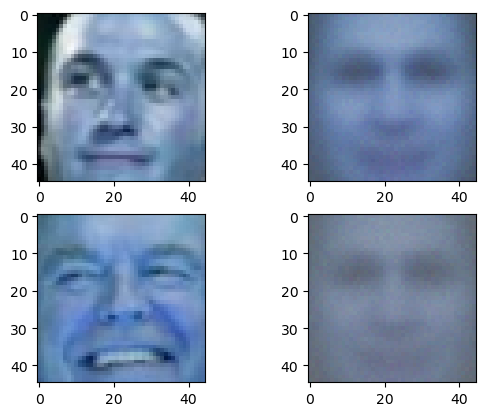

313/313 [==============================] - 4s 7ms/step - loss: 115.5215 - kl_loss: 5.2559 - reconstruction_loss: 110.2656
Epoch 2/50
313/313 [==============================] - 2s 5ms/step - loss: 92.8007 - kl_loss: 4.9729 - reconstruction_loss: 87.8278
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 90.8450 - kl_loss: 4.4545 - reconstruction_loss: 86.3904

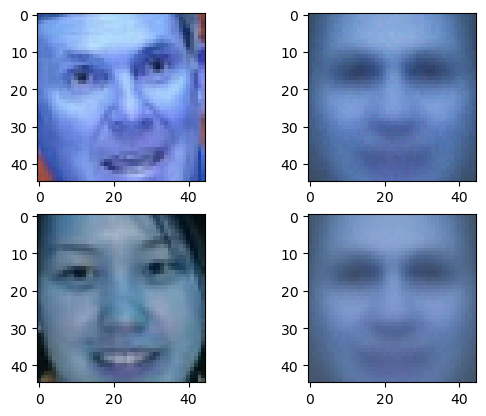

313/313 [==============================] - 2s 7ms/step - loss: 90.8834 - kl_loss: 4.4536 - reconstruction_loss: 86.4297
Epoch 4/50
313/313 [==============================] - 2s 5ms/step - loss: 87.2795 - kl_loss: 5.6213 - reconstruction_loss: 81.6582
Epoch 5/50
304/313 [============================>.] - ETA: 0s - loss: 83.0501 - kl_loss: 6.4324 - reconstruction_loss: 76.6178

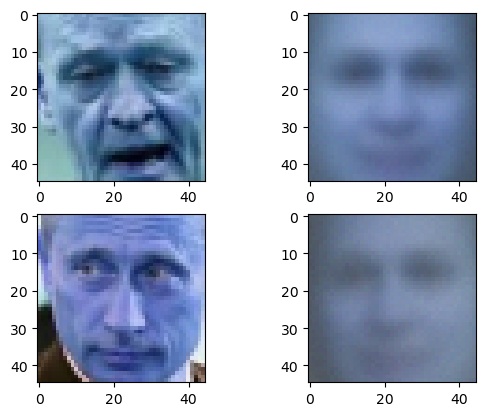

313/313 [==============================] - 2s 7ms/step - loss: 82.9867 - kl_loss: 6.4584 - reconstruction_loss: 76.5283
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 78.4653 - kl_loss: 7.1449 - reconstruction_loss: 71.3203
Epoch 7/50
307/313 [============================>.] - ETA: 0s - loss: 75.1018 - kl_loss: 7.6663 - reconstruction_loss: 67.4356

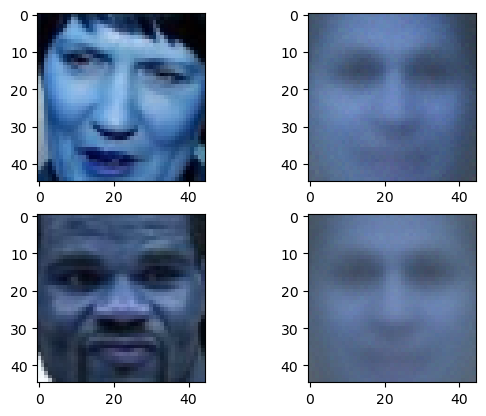

313/313 [==============================] - 2s 7ms/step - loss: 75.0463 - kl_loss: 7.6678 - reconstruction_loss: 67.3786
Epoch 8/50
313/313 [==============================] - 2s 6ms/step - loss: 72.3444 - kl_loss: 7.8839 - reconstruction_loss: 64.4605
Epoch 9/50
306/313 [============================>.] - ETA: 0s - loss: 70.5127 - kl_loss: 8.2321 - reconstruction_loss: 62.2806

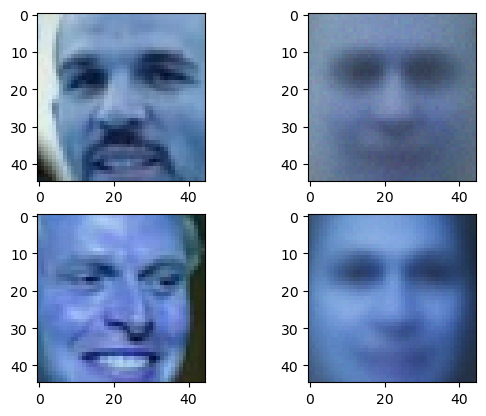

313/313 [==============================] - 2s 7ms/step - loss: 70.4872 - kl_loss: 8.2325 - reconstruction_loss: 62.2548
Epoch 10/50
313/313 [==============================] - 2s 6ms/step - loss: 69.0227 - kl_loss: 8.3329 - reconstruction_loss: 60.6898
Epoch 11/50
308/313 [============================>.] - ETA: 0s - loss: 68.0277 - kl_loss: 8.2749 - reconstruction_loss: 59.7528

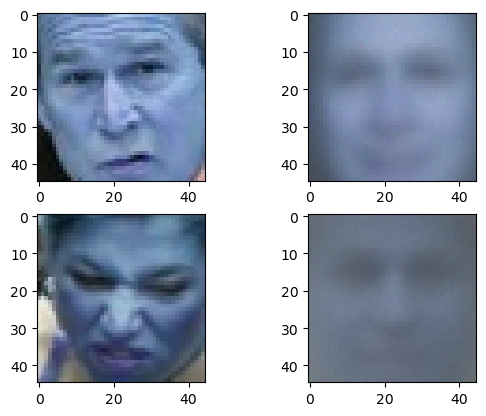

313/313 [==============================] - 2s 7ms/step - loss: 68.0573 - kl_loss: 8.2836 - reconstruction_loss: 59.7737
Epoch 12/50
313/313 [==============================] - 2s 6ms/step - loss: 67.2403 - kl_loss: 8.3062 - reconstruction_loss: 58.9341
Epoch 13/50
310/313 [============================>.] - ETA: 0s - loss: 66.5578 - kl_loss: 8.2667 - reconstruction_loss: 58.2911

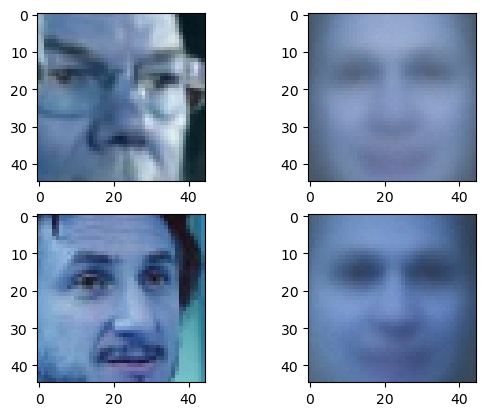

313/313 [==============================] - 2s 7ms/step - loss: 66.5896 - kl_loss: 8.2767 - reconstruction_loss: 58.3129
Epoch 14/50
313/313 [==============================] - 2s 6ms/step - loss: 66.0191 - kl_loss: 8.3583 - reconstruction_loss: 57.6608
Epoch 15/50
307/313 [============================>.] - ETA: 0s - loss: 65.3527 - kl_loss: 8.4233 - reconstruction_loss: 56.9293

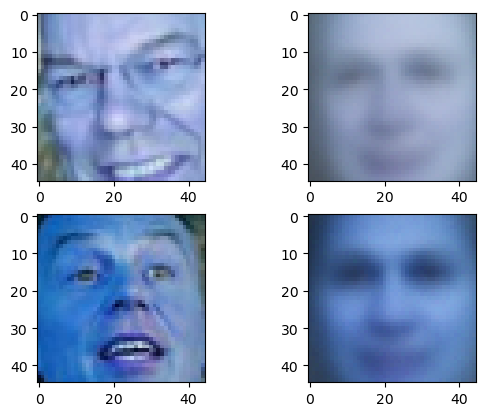

313/313 [==============================] - 2s 7ms/step - loss: 65.3186 - kl_loss: 8.4258 - reconstruction_loss: 56.8929
Epoch 16/50
313/313 [==============================] - 2s 6ms/step - loss: 64.6785 - kl_loss: 8.5280 - reconstruction_loss: 56.1506
Epoch 17/50
304/313 [============================>.] - ETA: 0s - loss: 63.8694 - kl_loss: 8.5711 - reconstruction_loss: 55.2983

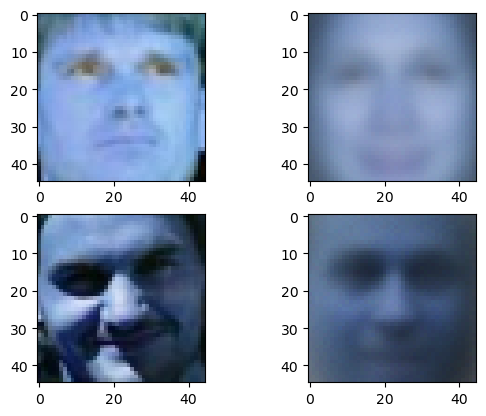

313/313 [==============================] - 2s 7ms/step - loss: 63.9517 - kl_loss: 8.5766 - reconstruction_loss: 55.3751
Epoch 18/50
313/313 [==============================] - 2s 6ms/step - loss: 63.6130 - kl_loss: 8.6950 - reconstruction_loss: 54.9180
Epoch 19/50
309/313 [============================>.] - ETA: 0s - loss: 63.0908 - kl_loss: 8.7317 - reconstruction_loss: 54.3591

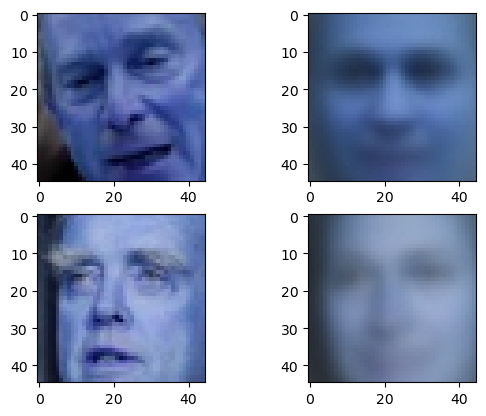

313/313 [==============================] - 2s 7ms/step - loss: 63.0501 - kl_loss: 8.7280 - reconstruction_loss: 54.3220
Epoch 20/50
313/313 [==============================] - 2s 6ms/step - loss: 62.5646 - kl_loss: 8.6801 - reconstruction_loss: 53.8846
Epoch 21/50
309/313 [============================>.] - ETA: 0s - loss: 62.3023 - kl_loss: 8.6677 - reconstruction_loss: 53.6345

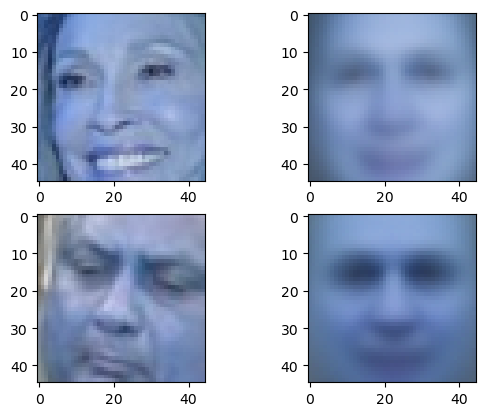

313/313 [==============================] - 2s 8ms/step - loss: 62.2752 - kl_loss: 8.6676 - reconstruction_loss: 53.6076
Epoch 22/50
313/313 [==============================] - 2s 6ms/step - loss: 62.1023 - kl_loss: 8.6824 - reconstruction_loss: 53.4199
Epoch 23/50
313/313 [==============================] - ETA: 0s - loss: 61.8196 - kl_loss: 8.6754 - reconstruction_loss: 53.1441

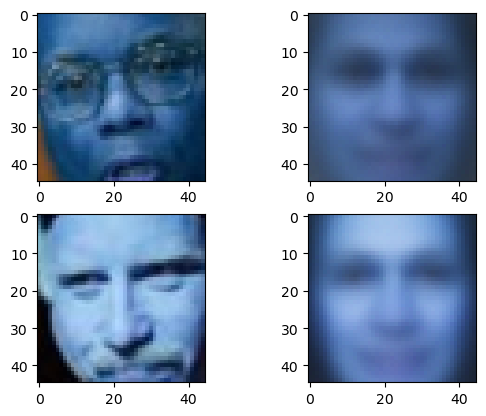

313/313 [==============================] - 2s 7ms/step - loss: 61.7893 - kl_loss: 8.6722 - reconstruction_loss: 53.1170
Epoch 24/50
313/313 [==============================] - 2s 6ms/step - loss: 61.5156 - kl_loss: 8.6179 - reconstruction_loss: 52.8977
Epoch 25/50
306/313 [============================>.] - ETA: 0s - loss: 61.5943 - kl_loss: 8.6768 - reconstruction_loss: 52.9175

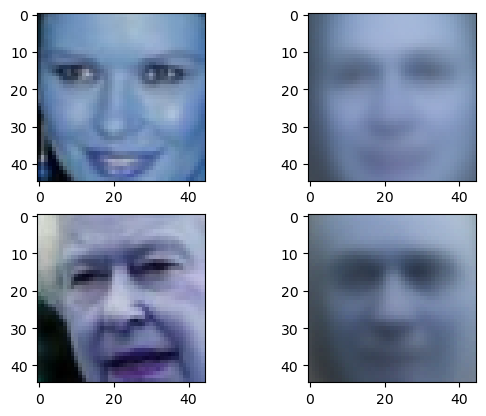

313/313 [==============================] - 2s 7ms/step - loss: 61.5790 - kl_loss: 8.6766 - reconstruction_loss: 52.9024
Epoch 26/50
313/313 [==============================] - 2s 6ms/step - loss: 61.3791 - kl_loss: 8.6618 - reconstruction_loss: 52.7173
Epoch 27/50
308/313 [============================>.] - ETA: 0s - loss: 61.0546 - kl_loss: 8.5559 - reconstruction_loss: 52.4987

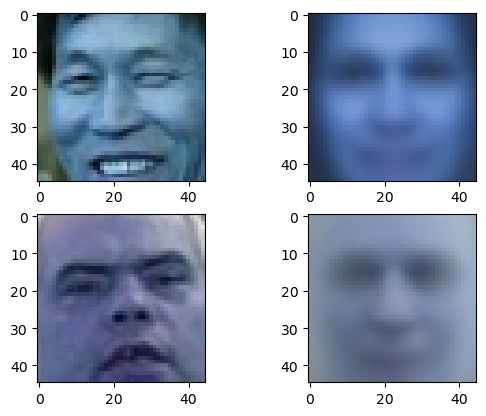

313/313 [==============================] - 2s 7ms/step - loss: 61.0271 - kl_loss: 8.5488 - reconstruction_loss: 52.4783
Epoch 28/50
313/313 [==============================] - 2s 6ms/step - loss: 60.8885 - kl_loss: 8.6370 - reconstruction_loss: 52.2515
Epoch 29/50
312/313 [============================>.] - ETA: 0s - loss: 60.6026 - kl_loss: 8.5413 - reconstruction_loss: 52.0613

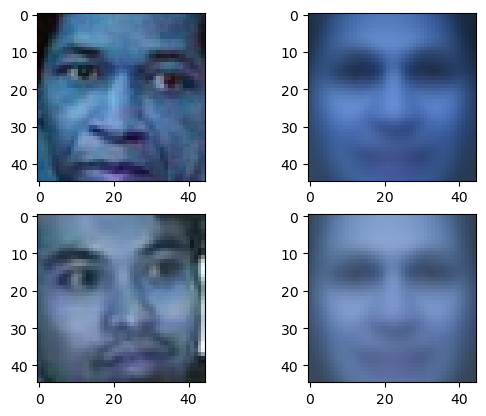

313/313 [==============================] - 2s 7ms/step - loss: 60.6004 - kl_loss: 8.5425 - reconstruction_loss: 52.0579
Epoch 30/50
313/313 [==============================] - 2s 6ms/step - loss: 60.6164 - kl_loss: 8.5858 - reconstruction_loss: 52.0306
Epoch 31/50
310/313 [============================>.] - ETA: 0s - loss: 60.5669 - kl_loss: 8.6240 - reconstruction_loss: 51.9429

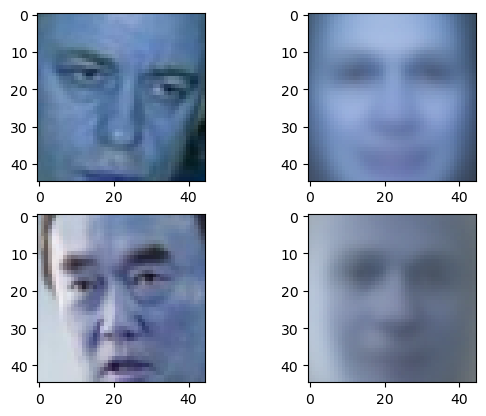

313/313 [==============================] - 2s 7ms/step - loss: 60.4979 - kl_loss: 8.6278 - reconstruction_loss: 51.8701
Epoch 32/50
313/313 [==============================] - 2s 6ms/step - loss: 60.3829 - kl_loss: 8.6285 - reconstruction_loss: 51.7544
Epoch 33/50
305/313 [============================>.] - ETA: 0s - loss: 60.1472 - kl_loss: 8.6301 - reconstruction_loss: 51.5171

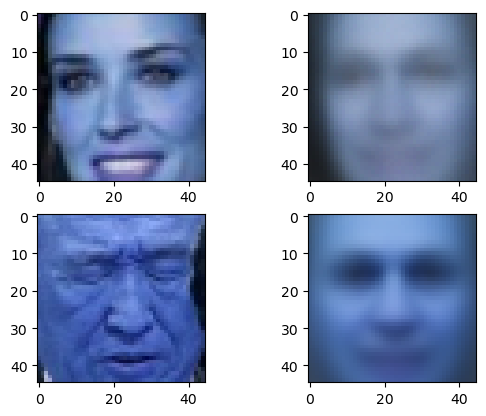

313/313 [==============================] - 2s 7ms/step - loss: 60.0817 - kl_loss: 8.6234 - reconstruction_loss: 51.4583
Epoch 34/50
313/313 [==============================] - 2s 6ms/step - loss: 59.9635 - kl_loss: 8.6256 - reconstruction_loss: 51.3379
Epoch 35/50
307/313 [============================>.] - ETA: 0s - loss: 59.8420 - kl_loss: 8.6572 - reconstruction_loss: 51.1848

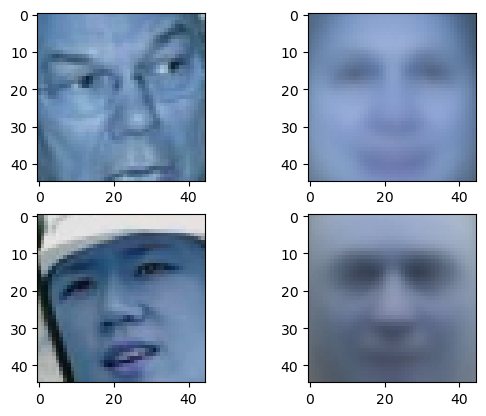

313/313 [==============================] - 2s 7ms/step - loss: 59.8447 - kl_loss: 8.6526 - reconstruction_loss: 51.1921
Epoch 36/50
313/313 [==============================] - 2s 6ms/step - loss: 59.6293 - kl_loss: 8.5891 - reconstruction_loss: 51.0402
Epoch 37/50
306/313 [============================>.] - ETA: 0s - loss: 59.4441 - kl_loss: 8.6081 - reconstruction_loss: 50.8360

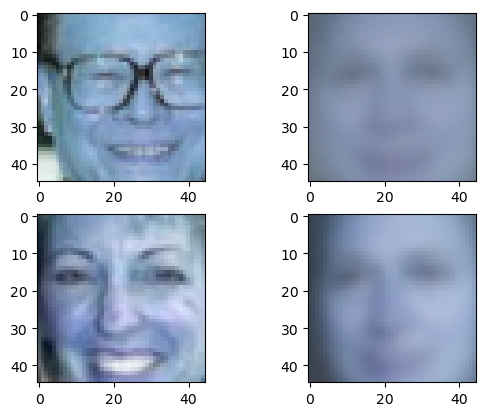

313/313 [==============================] - 3s 9ms/step - loss: 59.4879 - kl_loss: 8.6154 - reconstruction_loss: 50.8726
Epoch 38/50
313/313 [==============================] - 2s 6ms/step - loss: 59.3516 - kl_loss: 8.6757 - reconstruction_loss: 50.6759
Epoch 39/50
313/313 [==============================] - ETA: 0s - loss: 59.1790 - kl_loss: 8.7026 - reconstruction_loss: 50.4764

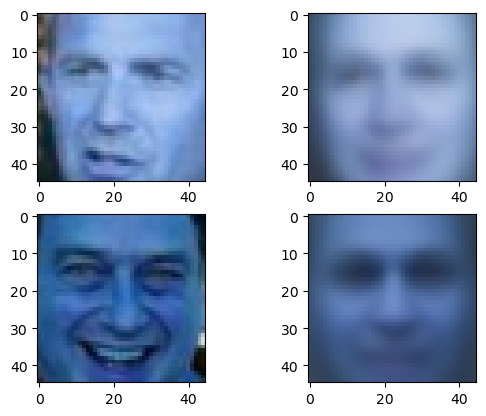

313/313 [==============================] - 2s 7ms/step - loss: 59.1632 - kl_loss: 8.7010 - reconstruction_loss: 50.4622
Epoch 40/50
313/313 [==============================] - 2s 6ms/step - loss: 59.0311 - kl_loss: 8.7156 - reconstruction_loss: 50.3155
Epoch 41/50
309/313 [============================>.] - ETA: 0s - loss: 58.7344 - kl_loss: 8.7361 - reconstruction_loss: 49.9982

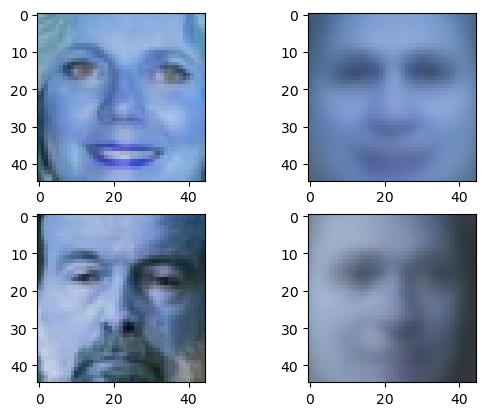

313/313 [==============================] - 2s 7ms/step - loss: 58.7099 - kl_loss: 8.7280 - reconstruction_loss: 49.9819
Epoch 42/50
313/313 [==============================] - 2s 6ms/step - loss: 58.5595 - kl_loss: 8.7788 - reconstruction_loss: 49.7807
Epoch 43/50
309/313 [============================>.] - ETA: 0s - loss: 58.3270 - kl_loss: 8.8240 - reconstruction_loss: 49.5030

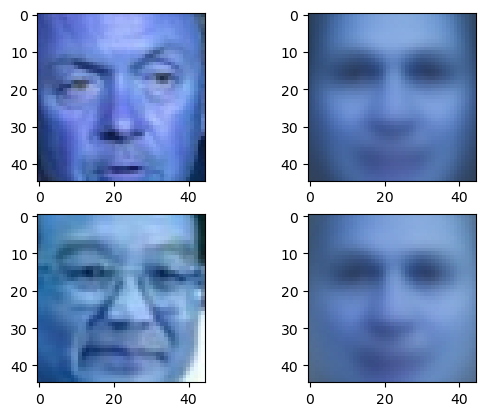

313/313 [==============================] - 2s 7ms/step - loss: 58.3101 - kl_loss: 8.8279 - reconstruction_loss: 49.4822
Epoch 44/50
313/313 [==============================] - 2s 6ms/step - loss: 58.2448 - kl_loss: 8.8216 - reconstruction_loss: 49.4232
Epoch 45/50
313/313 [==============================] - ETA: 0s - loss: 58.0816 - kl_loss: 8.9011 - reconstruction_loss: 49.1805

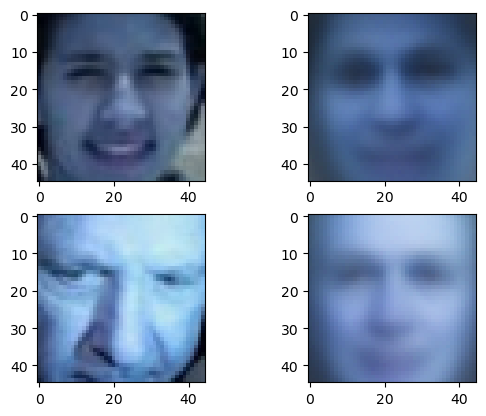

313/313 [==============================] - 2s 8ms/step - loss: 58.0852 - kl_loss: 8.9016 - reconstruction_loss: 49.1836
Epoch 46/50
313/313 [==============================] - 2s 6ms/step - loss: 57.8849 - kl_loss: 8.9567 - reconstruction_loss: 48.9282
Epoch 47/50
306/313 [============================>.] - ETA: 0s - loss: 57.7292 - kl_loss: 8.9262 - reconstruction_loss: 48.8030

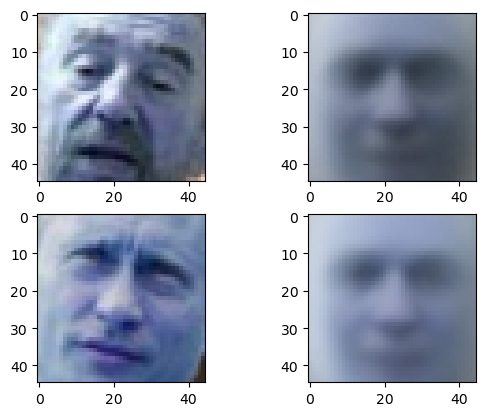

313/313 [==============================] - 2s 7ms/step - loss: 57.6135 - kl_loss: 8.9189 - reconstruction_loss: 48.6946
Epoch 48/50
313/313 [==============================] - 2s 6ms/step - loss: 57.5497 - kl_loss: 8.9979 - reconstruction_loss: 48.5518
Epoch 49/50
306/313 [============================>.] - ETA: 0s - loss: 57.4266 - kl_loss: 9.0733 - reconstruction_loss: 48.3533

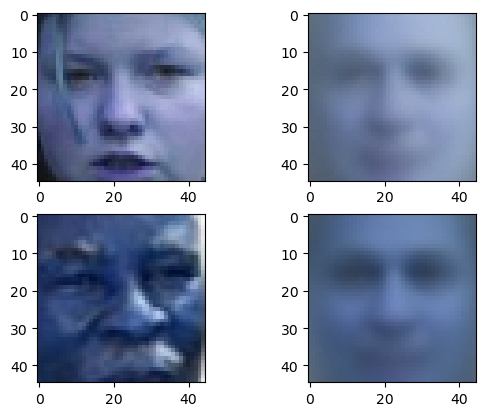

313/313 [==============================] - 2s 7ms/step - loss: 57.4421 - kl_loss: 9.0725 - reconstruction_loss: 48.3696
Epoch 50/50
313/313 [==============================] - 2s 6ms/step - loss: 57.3055 - kl_loss: 9.0266 - reconstruction_loss: 48.2789


In [12]:
#tf.compat.v1.enable_eager_execution()
history = vae.fit(X_train[:], X_train[:],
                  batch_size=32,
                  epochs=50,
                  callbacks=[callback])

Plot the learning curves

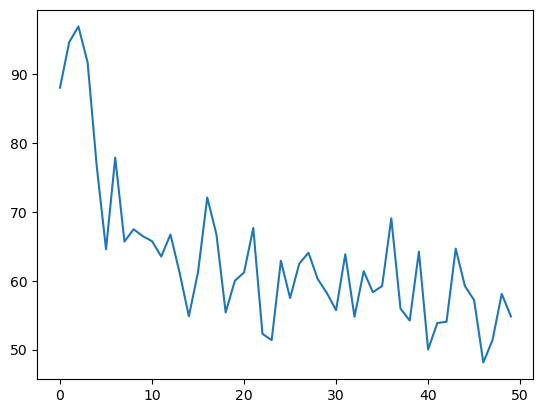

In [13]:
plt.plot(history.history['loss'])
plt.show()

And finally sample from VAE.

In [14]:
# TODO
# Sample some images from the learned distribution

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

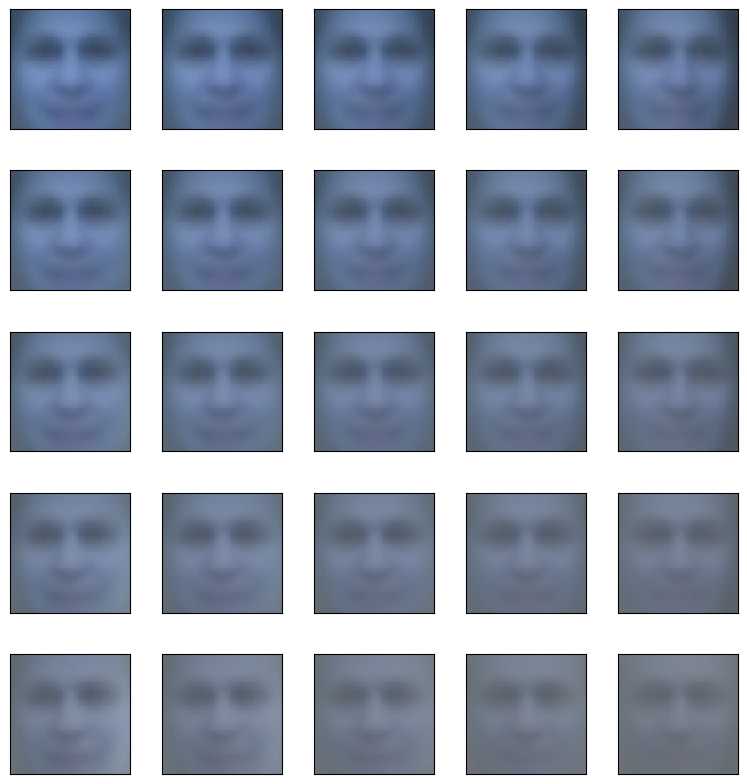

In [20]:
x=np.linspace(-1, 0.5, 5)
y=np.linspace(-1, 0.5, 5)
zeros = [0 for _ in range(dimZ-2)]
output=[]
for x1 in x:
    for y1 in y:
        output.append(decoder(np.array([[x1, y1]+zeros])).numpy())
plot_gallery(output, n_row=5, n_col=5)
plt.show()

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

In [103]:
smile_info = attrs['Smiling'].sort_values()
cnt_imgs = 10
smilers = smile_info[-cnt_imgs:]
frowners = smile_info[:cnt_imgs]

In [104]:
smilers_imgs = data[smilers.index].reshape(cnt_imgs, -1)/255
frowners_imgs = data[frowners.index].reshape(cnt_imgs, -1)/255

In [105]:
_, _, samples_smiler = encoder(smilers_imgs)
_, _, samples_frowner = encoder(frowners_imgs)

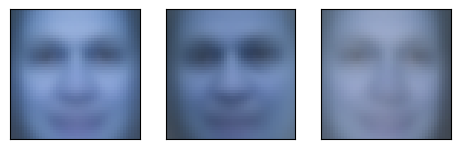

  smile                 frown                 mix


In [106]:
avg_smiler = decoder(np.array([tf.reduce_mean(samples_smiler, axis=0)])).numpy()
avg_frowner = decoder(np.array([tf.reduce_mean(samples_frowner, axis=0)])).numpy()
smile_imgs_all = np.append(avg_smiler, avg_frowner, axis=0)
avg_neutral = decoder(np.array([tf.reduce_mean(samples_smiler-samples_frowner, axis=0)])).numpy()
smile_imgs_all = np.append(smile_imgs_all, avg_neutral, axis=0)
plot_gallery(smile_imgs_all, n_row=1, n_col=3)
print('  smile',' '*15, 'frown', ' '*15, 'mix')

In [77]:
frowners_imgs[:10].shape

(10, 60750)

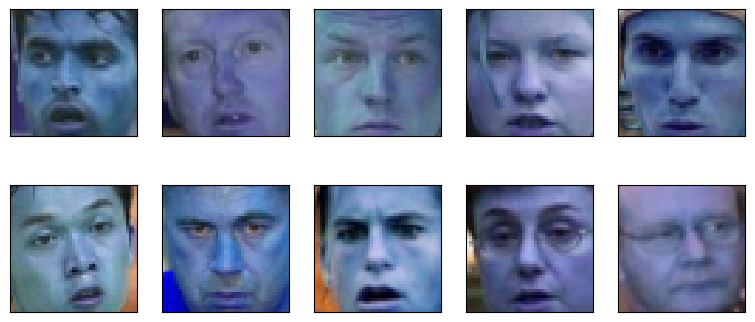

In [107]:
plot_gallery(frowners_imgs[:10], n_row=2, n_col=5)

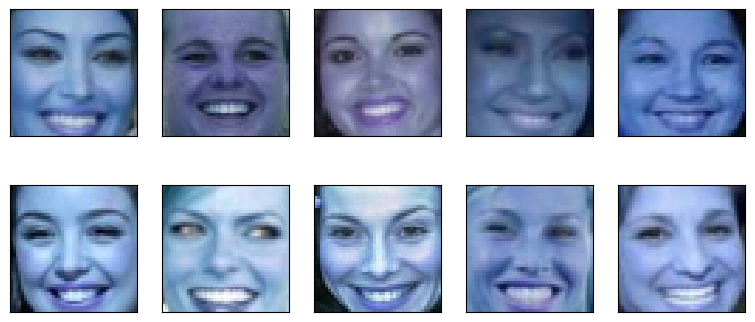

In [108]:
plot_gallery(smilers_imgs[:10], n_row=2, n_col=5)